In [156]:

import torch
# from tbparse import SummaryReader
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 14})

# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

## function development

In [184]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "roberta-base-cris": "RoBERTa-cris",
    "roberta-base-declutr-2_anch_2_pos_min_64":"RoBERTA-cris-DeCLUTR",
    "roberta-base-cris-note-custom_pretraining_1":"RoBERTa-cris-note",
    "Bio_ClinicalBERT": "Bio-ClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
                           
                            
    }

# task name mappings

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",}

In [190]:
def get_configs(modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logdir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

In [159]:
# def get_trainer_args(modeldir):
#     with open(logdir + modeldir + '/all_trainer_args.yaml') as f:
#         trainer_args= yaml.load(f, Loader=yaml.FullLoader)
#         trainer_args['dir_name'] = modeldir
#     return trainer_args

In [195]:
# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(logdir, extra_columns={'dir_name'})
    df = reader.scalars
    
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(lambda x: get_configs(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')
    
    # we want to replace few_shot_n nan values with few_shot_n = "full"
    merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))
    
    
    return merged_df

### debugging

In [161]:
logdir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars


In [162]:
config_list = df["dir_name"].drop_duplicates().apply(lambda x: get_configs(x))
config_df = pd.DataFrame.from_records(config_list)
df = pd.merge(df, config_df, on='dir_name')

In [163]:
df.peft_method.value_counts()

peft_method
LORA             41642
PREFIX_TUNING     2412
PROMPT_TUNING     2412
P_TUNING          2412
Full              2088
Name: count, dtype: int64

## Load in events files



In [196]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'
logs_df = read_tb_files(logs_dir)

  0%|          | 0/135 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/bio-mobilebert/Full/21-07-2023--14-43/config.yaml'


  0%|          | 0/50966 [00:00<?, ?it/s]

In [165]:
logs_df.head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name
0,1437,eval/accuracy,0.984213,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
1,2874,eval/accuracy,0.988822,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
2,4311,eval/accuracy,0.990410,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
3,5748,eval/accuracy,0.991725,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
4,7185,eval/accuracy,0.991706,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert


In [166]:
logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'data_dir', 'dropout', 'eight_bit_training',
       'eval_batch_size', 'eval_data_dir', 'eval_every_steps',
       'eval_few_shot_n', 'evaluation_strategy', 'fast_dev_run', 'few_shot_n',
       'label_col', 'label_name', 'loader_workers', 'log_every_steps',
       'log_save_dir', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'no_cuda', 'optimizer', 'patience',
       'peft_method', 'pretrained_models_dir', 'save_every_steps',
       'saving_strategy', 'sensitivity', 'task', 'task_to_keys', 'task_type',
       'test_file', 'text_col', 'train_batch_size', 'training_data_dir',
       'training_file', 'validation_file', 'warmup_steps', 'remove_columns',
       'text_column', 'accumulate_grad_batches', 'classifier_learning_rate',
       'encoder_learning_rate', 'eval_accumulation_steps', 'gpu_idx',
       'max_steps', 'model_type', 'training_size', '

In [167]:
logs_df.model_name_or_path.unique()

array(['nlpie/distil-biobert',
       '/mnt/sdc/niallt/saved_models/language_modelling/mimic/mimic-roberta-base/sampled_250000/22-12-2022--12-45/checkpoint-100000/',
       '/mnt/sdc/niallt/saved_models/declutr/mimic/few_epoch/mimic-roberta-base/2_anch_2_pos_min_1024/transformer_format/',
       'roberta-base', 'emilyalsentzer/Bio_ClinicalBERT',
       'michiyasunaga/LinkBERT-base', 'decapoda-research/llama-7b-hf',
       'ybelkada/falcon-7b-sharded-bf16',
       'michiyasunaga/BioLinkBERT-base', 'nlpie/bio-mobilebert',
       '/mnt/sdc/niallt/saved_models/language_modelling/mimic/roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted/sampled_250000/07-07-2023--08-30/checkpoint-30000/',
       'nlpie/tiny-biobert'], dtype=object)

In [168]:
logs_df["Model name"].unique()

array(['distil-biobert', 'mimic-roberta-base',
       'mimic-roberta-base/declutr/2_anch_2_pos_min_1024', 'roberta-base',
       'Bio_ClinicalBERT', 'LinkBERT-base', 'llama-7b-hf',
       'falcon-7b-sharded-bf16', 'BioLinkBERT-base', 'bio-mobilebert',
       'roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

In [169]:
# check unique tasks 
logs_df.task.value_counts()

task
icd9-triage-no-category-in-text    21356
mimic-mp                           11676
i2b2-2014-NER                       8868
mimic-los                           7500
icd9-triage                         1566
Name: count, dtype: int64

In [170]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1', 'eval/loss', 'eval/precision',
       'eval/recall', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'train/epoch', 'train/learning_rate',
       'train/loss', 'train/total_flos', 'train/train_loss',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'eval/f1_macro',
       'eval/f1_weighted', 'eval/roc_auc_macro'], dtype=object)

In [171]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250.,  16., 200.,  32.,  64.])

In [172]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name
0,1437,eval/accuracy,0.984213,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
1,2874,eval/accuracy,0.988822,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
2,4311,eval/accuracy,0.990410,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
3,5748,eval/accuracy,0.991725,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
4,7185,eval/accuracy,0.991706,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49329,2124,eval/recall,0.565446,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49330,3186,eval/recall,0.610209,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49331,4248,eval/recall,0.603068,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49332,5310,eval/recall,0.591155,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base


In [173]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name


In [174]:
def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",
                    tasks = ['mimic-mp'], 
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks...
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df[logs_df["tag"].str.contains(metrics)]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

In [175]:
metrics_df = extract_metric(logs_df, mode = "eval", metrics = ["f1","accuracy"], tasks = ['mimic-mp','mimic-los'], sample_sizes = [999], save_csv = False)

In [176]:
metrics_df

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,data_dir,dropout,eight_bit_training,...,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,custom_model_name,Model name
0,1437,eval/accuracy,0.984213,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
1,2874,eval/accuracy,0.988822,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
2,4311,eval/accuracy,0.990410,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
3,5748,eval/accuracy,0.991725,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
4,7185,eval/accuracy,0.991706,i2b2-2014-NER/full/distil-biobert/LORA/13-07-2...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,/mnt/sdd/efficient_ml_data/datasets/i2b2-2014_...,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distil-biobert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49311,2124,eval/f1_weighted,0.869461,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49312,3186,eval/f1_weighted,0.874068,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49313,4248,eval/f1_weighted,0.876040,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base
49314,5310,eval/f1_weighted,0.875286,mimic-mp/full/roberta-base/LORA/17-07-2023--11-34,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,,0.1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,roberta-base


In [177]:
def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            tasks = ["mimic-mp"],
                            value_aggregate_method = "mean",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        tb_metrics = extract_metric( logs_df, tasks = tasks, metrics = metric,
                                            mode = mode)
        

        # remove eval from the tag column
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"{mode}/",'')
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

In [178]:
results_df = produce_results_table(logs_df, 
                                        metric = ["f1_macro","accuracy"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "task","few_shot_n", "peft_method"],
                                        tasks = ["icd9-triage-no-category-in-text","mimic-mp"],
                                        value_aggregate_method = "max",
                                        )

/tmp/ipykernel_41102/784947041.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"{mode}/",'')


In [179]:
results_df

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1_macro
0,0,BioLinkBERT-base,icd9-triage,250.0,LORA,0.949904,0.878210
1,1,BioLinkBERT-base,mimic-mp,250.0,LORA,0.900163,0.651606
2,2,Bio_ClinicalBERT,icd9-triage-no-category-in-text,16.0,LORA,0.332370,0.165953
3,3,Bio_ClinicalBERT,icd9-triage-no-category-in-text,16.0,PREFIX_TUNING,0.445408,0.263398
4,4,Bio_ClinicalBERT,icd9-triage-no-category-in-text,16.0,PROMPT_TUNING,0.257225,0.122949
...,...,...,...,...,...,...,...
124,124,roberta-base,mimic-mp,250.0,LORA,0.897310,0.632734
125,125,roberta-base-mimic-note-custom_pretraining_max...,icd9-triage,250.0,LORA,0.948940,0.877642
126,126,roberta-base-mimic-note-custom_pretraining_max...,mimic-mp,250.0,LORA,0.899552,0.639914
127,127,tiny-biobert,icd9-triage-no-category-in-text,250.0,Full,0.914579,0.693878


In [180]:
sample_sizes = sorted(set(results_df['few_shot_n'].unique()))

In [181]:
results_df.query("`Model name` == 'roberta-base' & task == @task")

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1_macro
105,105,roberta-base,icd9-triage-no-category-in-text,16.0,LORA,0.213552,0.096331
106,106,roberta-base,icd9-triage-no-category-in-text,16.0,PREFIX_TUNING,0.598266,0.299290
107,107,roberta-base,icd9-triage-no-category-in-text,16.0,PROMPT_TUNING,0.296724,0.177550
108,108,roberta-base,icd9-triage-no-category-in-text,16.0,P_TUNING,0.237636,0.178080
109,109,roberta-base,icd9-triage-no-category-in-text,32.0,LORA,0.703918,0.297146
110,110,roberta-base,icd9-triage-no-category-in-text,32.0,PREFIX_TUNING,0.668593,0.400470
111,111,roberta-base,icd9-triage-no-category-in-text,32.0,PROMPT_TUNING,0.597302,0.220535
112,112,roberta-base,icd9-triage-no-category-in-text,32.0,P_TUNING,0.707129,0.252160
113,113,roberta-base,icd9-triage-no-category-in-text,64.0,LORA,0.858060,0.732975
114,114,roberta-base,icd9-triage-no-category-in-text,64.0,PREFIX_TUNING,0.844573,0.709982


In [182]:
results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")

tag,index,Model name,task,few_shot_n,peft_method,accuracy,f1_macro
121,121,roberta-base,icd9-triage-no-category-in-text,250.0,Full,0.941875,0.870992
122,122,roberta-base,icd9-triage-no-category-in-text,250.0,LORA,0.942839,0.868572


### Example plot of f1 macro for specific task

<Figure size 1200x1000 with 0 Axes>

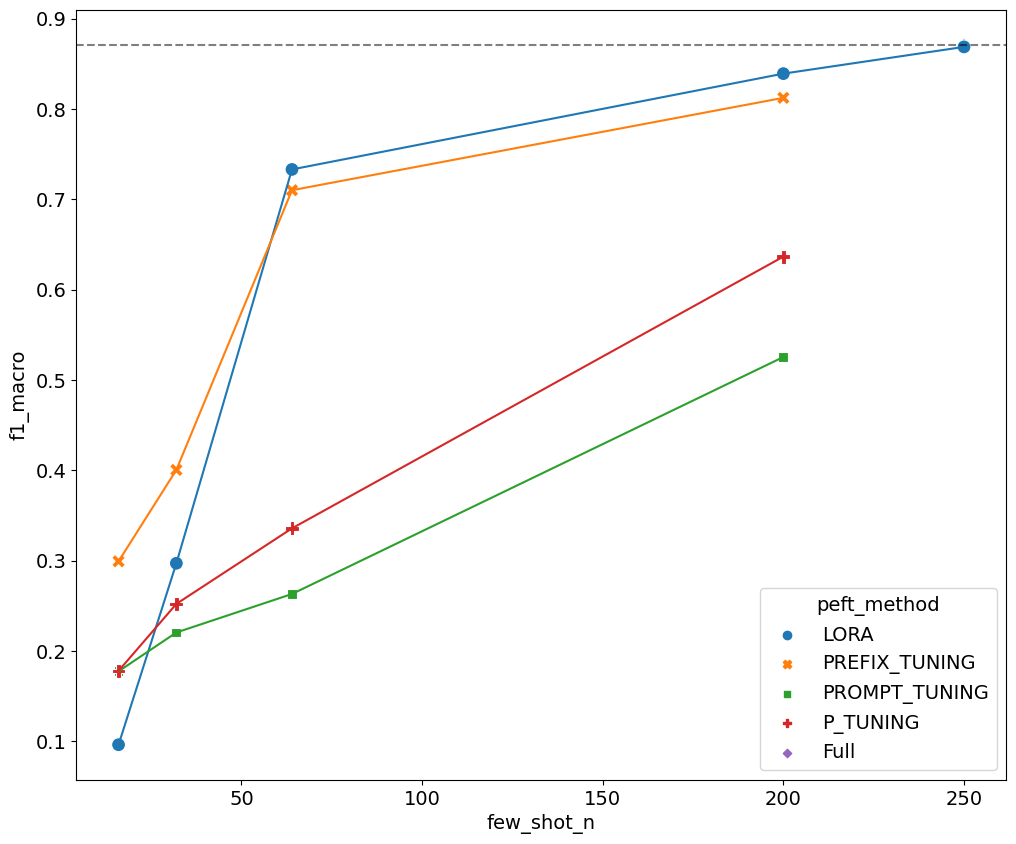

<Figure size 1200x1000 with 0 Axes>

In [183]:
# plot the f1 for one model across few shot sizes and peft method

# some plot params
        # now set x_tick_labels to be used later

# now we want string versions of these to set to xtick labels

task = "icd9-triage-no-category-in-text"
sample_size_x_ticks = [str(x) for x in sample_sizes]

# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = results_df.query("`Model name` == 'roberta-base' & task == @task"),
                    x = "few_shot_n",
                    y = "f1_macro",
                    hue = "peft_method",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = results_df.query("`Model name` == 'roberta-base' & task == @task"),
                        x = "few_shot_n",
                        y = "f1_macro",
                        hue = "peft_method",
                        ax =ax, 
                        legend = False
)


# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


ax.axhline(y=results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)



           

### Can also look at averages across tasks

not sure if good idea or not, but may be useful to look at averages across tasks

In [ ]:
results_df = produce_results_table(logs_df, 
                                        metric = ["f1_macro","accuracy"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "few_shot_n", "peft_method"],
                                        tasks = ["icd9-triage-no-category-in-text","mimic-mp"],
                                        value_aggregate_method = "max",
                                        )